In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

In [2]:
!unzip /content/alzheimer.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Non_Demented/non_1395.jpg  
  inflating: Dataset/Non_Demented/non_1396.jpg  
  inflating: Dataset/Non_Demented/non_1397.jpg  
  inflating: Dataset/Non_Demented/non_1398.jpg  
  inflating: Dataset/Non_Demented/non_1399.jpg  
  inflating: Dataset/Non_Demented/non_14.jpg  
  inflating: Dataset/Non_Demented/non_140.jpg  
  inflating: Dataset/Non_Demented/non_1400.jpg  
  inflating: Dataset/Non_Demented/non_1401.jpg  
  inflating: Dataset/Non_Demented/non_1402.jpg  
  inflating: Dataset/Non_Demented/non_1403.jpg  
  inflating: Dataset/Non_Demented/non_1404.jpg  
  inflating: Dataset/Non_Demented/non_1405.jpg  
  inflating: Dataset/Non_Demented/non_1406.jpg  
  inflating: Dataset/Non_Demented/non_1407.jpg  
  inflating: Dataset/Non_Demented/non_1408.jpg  
  inflating: Dataset/Non_Demented/non_1409.jpg  
  inflating: Dataset/Non_Demented/non_141.jpg  
  inflating: Dataset/Non_Demented/non_1410.jpg  
  inflating: Dataset/N

In [3]:
import os
import cv2

In [5]:
DIRECTORY = "/content/Dataset"
CATEGORIES = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]
IMAGES = []

In [6]:
import cv2
import os

# Assuming DIRECTORY and CATEGORIES are defined
# Initialize IMAGES list to store the grayscale images and their labels
IMAGES = []

for folder in CATEGORIES:
    folder_path = os.path.join(DIRECTORY, folder)
    for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file)

        # Read the image
        image = cv2.imread(image_path)

        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Resize the grayscale image
        gray_image_resized = cv2.resize(gray_image, (64, 64))

        # Get the label index
        label = CATEGORIES.index(folder)

        # Append the grayscale image and its label to the IMAGES list
        IMAGES.append([gray_image_resized, label])

    print(folder, " is completed".capitalize())


Mild_Demented  is completed
Moderate_Demented  is completed
Non_Demented  is completed
Very_Mild_Demented  is completed


In [ ]:
len(IMAGES)

6400

In [7]:
X = []
Y = []

for x, y in IMAGES:
  X.append(x)
  Y.append(y)

In [ ]:
len(X), len(Y)

(6400, 6400)

In [8]:
import numpy as np
X = np.array(X)/255.0

In [9]:
import torch

X = X.reshape(-1, 1, 64, 64)

X = torch.tensor(data = X, dtype = torch.float32)
y = torch.tensor(data = Y, dtype = torch.long)

In [ ]:
X.shape

torch.Size([6400, 1, 64, 64])

In [13]:
# transform = transforms.Compose([
#     transforms.Resize(64),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5), (0.5)),
# ])

# batch_size = 128
# dataset = datasets.MNIST(root='./data', download=True, transform=transform)
dataloader = DataLoader(dataset = list(zip(X, y)), batch_size=64, shuffle=True)

In [ ]:
data, label = next(iter(dataloader))

data.shape

torch.Size([128, 3, 64, 64])

In [ ]:
label

tensor([2, 3, 3, 2, 3, 0, 3, 3, 2, 2, 0, 3, 2, 2, 3, 3, 2, 3, 3, 2, 2, 2, 3, 3,
        2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 1, 0, 2, 3, 2, 0, 2, 3, 3, 3, 2, 2, 2, 2,
        3, 3, 2, 2, 2, 2, 0, 3, 3, 2, 2, 2, 2, 3, 2, 2])

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class netG(nn.Module):
    def __init__(self, nz, ngf, nc, nb_label):
        super(netG, self).__init__()
        self.label_emb = nn.Embedding(nb_label, nz)
        self.nz = nz
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz * 2, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, noise, labels):
        label_emb = self.label_emb(labels).view(-1, self.nz, 1, 1)
        combined_input = torch.cat([noise, label_emb], 1)
        output = self.main(combined_input)
        return output

class netD(nn.Module):
    def __init__(self, ndf, nc, nb_label):
        super(netD, self).__init__()
        self.ndf = ndf
        self.nb_label = nb_label

        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1 + nb_label, 4, 1, 0, bias=False),
            # Output size. (1 + nb_label) x 1 x 1 (real/fake and class logits)
        )

    def forward(self, input):
        output = self.main(input)
        output = output.view(-1, 1 + self.nb_label)
        real_fake = torch.sigmoid(output[:, 0:1])
        classes = F.log_softmax(output[:, 1:], dim=1)
        return real_fake, classes


In [15]:
# Hyperparameters
# z_dim = 100
# num_classes = 10
# img_channels = 3
# lr = 0.0002
# beta1 = 0.5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Model
# generator = netG(64, 3, 10).to(device)
# discriminator = netD(64,10).to(device)

# # Optimizers
# opt_gen = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
# opt_disc = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# # Loss function
# adversarial_loss = nn.BCELoss()
# auxiliary_loss = nn.CrossEntropyLoss()


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming the generator (netG), discriminator (netD), dataloader, device, etc. are defined elsewhere
num_epochs = 200
num_classes = 4 # Number of classes for the dataset
z_dim = 50 # Size of z latent vector (i.e., generator input)

# Initialize BCELoss function
adversarial_loss = nn.BCELoss()
auxiliary_loss = nn.CrossEntropyLoss() # Assuming labels are class indices

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.
nz = 50
ngf = 64
nc = 1
ndf = 64
nb_label = 4

# Create instances of the generator and discriminator
netG_instance = netG(nz, ngf, nc, nb_label).to(device) # Updated netG initialization
netD_instance = netD(ndf, nc, nb_label).to(device)

# Setup Adam optimizers for both G and D using instances
opt_gen = optim.Adam(netG_instance.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_disc = optim.Adam(netD_instance.parameters(), lr=0.0002, betas=(0.5, 0.999))

for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        batch_size = imgs.size(0)

        # Send real images and labels to device
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # Generate random noise and random labels for fake images
        noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
        gen_labels = torch.randint(0, num_classes, (batch_size,), device=device) # Use gen_labels for clarity

        ############################
        # (1) Update D network
        ###########################
        netD_instance.zero_grad()

        # Train with all-real batch
        real_output, real_aux_labels = netD_instance(real_imgs)
        errD_real = adversarial_loss(real_output.view(-1), torch.full((batch_size,), real_label, device=device)) + auxiliary_loss(real_aux_labels, labels)

        # Generate fake images batch using generator, now with labels
        fake_imgs = netG_instance(noise, gen_labels) # Updated to include gen_labels
        fake_output, fake_aux_labels = netD_instance(fake_imgs.detach())
        errD_fake = adversarial_loss(fake_output.view(-1), torch.full((batch_size,), fake_label, device=device)) +  auxiliary_loss(fake_aux_labels, gen_labels)
        total_D_loss = errD_real + errD_fake * 0.5
        total_D_loss.backward()

        # Update discriminator
        opt_disc.step()

        ############################
        # (2) Update G network
        ###########################
        netG_instance.zero_grad()

        # Perform another forward pass of all-fake batch through D
        output, aux_labels = netD_instance(fake_imgs)
        errG = 0.5 * adversarial_loss(output.view(-1), torch.full((batch_size,), real_label, device=device)) + 0.5 * auxiliary_loss(aux_labels, gen_labels)
        errG.backward()

        # Update generator
        opt_gen.step()

        if i % 50 == 0:  # Print log info every 50 batches
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] Loss_D: {errD_real.item() + errD_fake.item()}, Loss_G: {errG.item()}')



[0/200][0/100] Loss_D: 4.536846399307251, Loss_G: 0.9671739339828491
[0/200][50/100] Loss_D: 0.7885192260146141, Loss_G: 2.065307855606079
[1/200][0/100] Loss_D: 2.8583714962005615, Loss_G: 2.0526554584503174
[1/200][50/100] Loss_D: 1.3164320290088654, Loss_G: 1.1261086463928223
[2/200][0/100] Loss_D: 0.5487936437129974, Loss_G: 1.6289501190185547
[2/200][50/100] Loss_D: 1.3781266510486603, Loss_G: 2.118908405303955
[3/200][0/100] Loss_D: 0.30733368545770645, Loss_G: 1.7360252141952515
[3/200][50/100] Loss_D: 1.7980849482119083, Loss_G: 0.26462268829345703
[4/200][0/100] Loss_D: 0.32564852200448513, Loss_G: 2.3320701122283936
[4/200][50/100] Loss_D: 0.23970802128314972, Loss_G: 1.8248006105422974
[5/200][0/100] Loss_D: 0.21124666929244995, Loss_G: 2.21749210357666
[5/200][50/100] Loss_D: 0.2090746909379959, Loss_G: 2.3863837718963623
[6/200][0/100] Loss_D: 0.09323866292834282, Loss_G: 2.034092903137207
[6/200][50/100] Loss_D: 0.04974350892007351, Loss_G: 2.677938461303711
[7/200][0/100

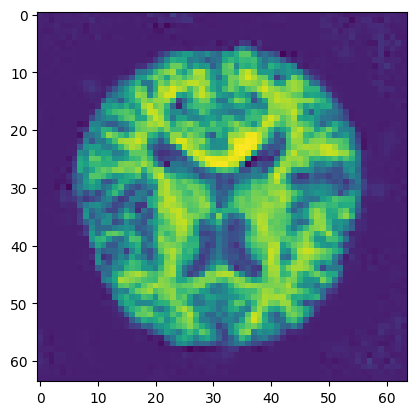

In [17]:
import torch

# Parameters
desired_label = 0  # The label for which you want to generate images
num_images = 10  # The number of images you want to generate

# Generate input noise and labels
noise = torch.randn(num_images, z_dim, 1, 1, device=device)
labels = torch.full((num_images,), desired_label, dtype=torch.long, device=device)

# Generate images
with torch.no_grad():  # We don't need to track gradients here
    generated_images = netG_instance(noise, labels)

# You can now visualize or save generated_images as needed
# Example: Save or display the first generated image
import matplotlib.pyplot as plt

# Assuming the generated images are normalized in the range [-1, 1], we denormalize them to [0, 1]
img = generated_images[0].detach().cpu().numpy()
img = (img + 1) / 2
img = np.transpose(img, (1, 2, 0))  # Change from (C, H, W) to (H, W, C) for visualization

plt.imshow(img)
plt.show()

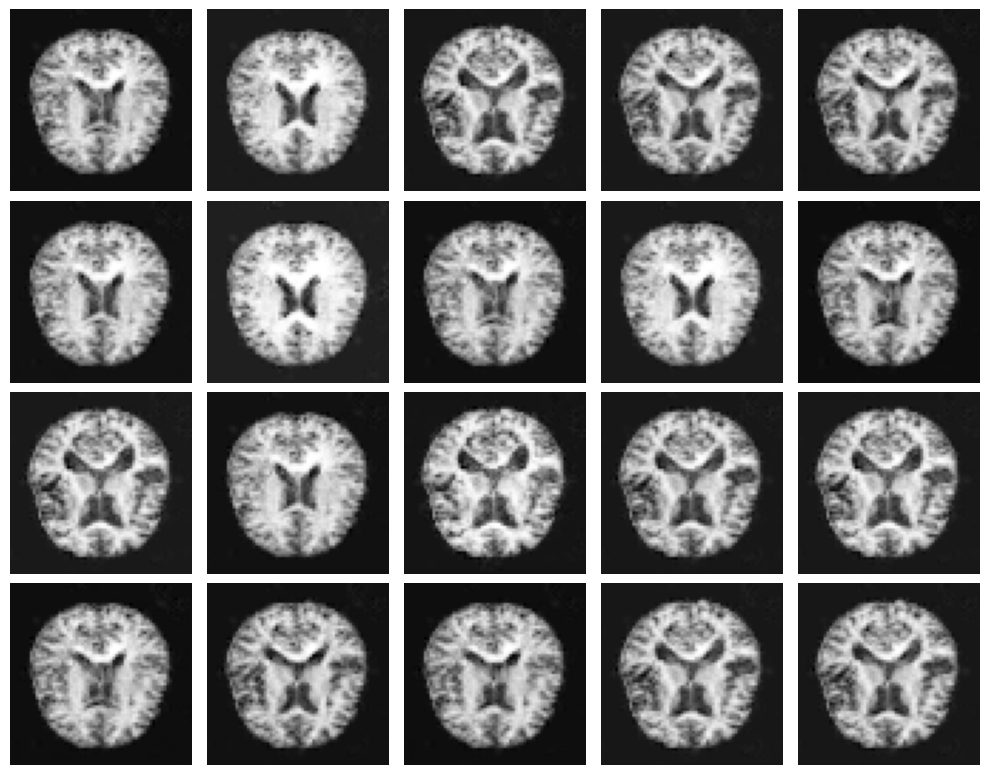

In [23]:
import torch

# Parameters
desired_label = 0  # The label for which you want to generate images
num_images = 20  # The number of images you want to generate

# Generate input noise and labels
noise = torch.randn(num_images, z_dim, 1, 1, device=device)
labels = torch.full((num_images,), desired_label, dtype=torch.long, device=device)

# Generate images
with torch.no_grad():  # We don't need to track gradients here
    generated_images = netG_instance(noise, labels)

import matplotlib.pyplot as plt
import numpy as np

# Assuming generated_images is a batch of images with shape (num_images, channels, height, width)
# And you have 20 images you want to display

# Setting up the figure size and grid
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))
fig.tight_layout(pad=3.0)

for i, ax in enumerate(axes.flat):
    # Assuming the generated images are normalized in the range [-1, 1], we denormalize them to [0, 1]
    img = generated_images[i].detach().cpu().numpy()
    img = (img + 1) / 2
    img = np.transpose(img, (1, 2, 0))  # Change from (C, H, W) to (H, W, C) for visualization

    # If the images are grayscale, img will have shape (H, W, 1); we squeeze the last dimension for display
    if img.shape[2] == 1:
        img = np.squeeze(img, axis=2)

    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.tight_layout()

# Display the figure with the images
plt.show()